<h1>AI2 - PROJECT3 - FOUKANELIS CHRISTOS GEORGIOS - 1115201900204<h1>
TESTING NOTEBOOK

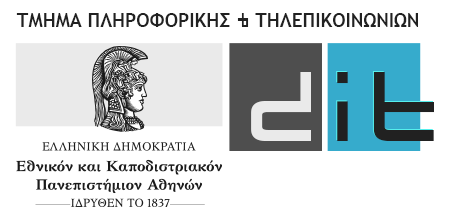

PIPELINE FOR TESTING

In [ ]:
import torch
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
nltk.download('stopwords') 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import re
import time
import os
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
import matplotlib.patches as mpatches
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, roc_auc_score
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
#import optuna
import torch.optim as optim
from tqdm.notebook import tqdm # for a continuous progress bar style
import torch.nn.functional as F
%matplotlib inline
from torchtext.data import Field,LabelField,BucketIterator,TabularDataset # TorchText has Text processing Function
from torchtext import vocab
from sklearn.model_selection import train_test_split # split the data into training and testing
from sklearn.metrics import accuracy_score # accuracy metric
from nltk import word_tokenize # very popular Text processing Library
from nltk import punkt
import random # to perform randomisation of tasks
from tqdm.notebook import tqdm # for a continuous progress bar style
import optuna

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
!unzip glove.6B.zip

In [ ]:
SEED = 13 # reproducible results: Same results in every run
IN_PATH = ''
DATA_PATH = '' 
OUT_PATH = ''
MODEL_FILE = ''

#################### INSERT TEST CSV FILE HERE#####################
TEST_FILE_PATH = ''
###################################################################

GLOVE_TEXT_PATH = 'glove.6B.200d.txt' # glove directory
EPOCH = 10 # number of epochs to run for model

np.random.seed(SEED) 
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True  # cuda algorithms
os.environ['PYTHONHASHSEED'] = str(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use 'cuda' if available else 'cpu'

plt.style.use('seaborn') # use seaborn style plotting


In [ ]:
cachedStopWords = stopwords.words("english")

def remove_links(x):
    return re.sub(r"http\S+", "", x)

def remove_punctuation(x):
    return re.sub(r'[^\w\s]', '', x)

def lowercase(x):
    return x.lower()

def remove_stopwords(x):
    return ' '.join([word for word in x.split() if word not in cachedStopWords])

def remove_html(x):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', x)

def sentiment_label(x):
    if x >= 7.0:
        return 1
    elif x <= 4.0:
        return 0
    
def word_count(x):
    return len(x.split(' '))

In [ ]:
test_df = pd.read_csv(TEST_FILE_PATH,sep = '\t', engine = 'python')
# clean the data
test_df['review'] = test_df['review'].apply(remove_links)
test_df['review'] = test_df['review'].apply(lowercase)
test_df['review'] = test_df['review'].apply(remove_punctuation)
test_df['review'] = test_df['review'].apply(remove_stopwords)
test_df['review'] = test_df['review'].apply(remove_html)
test_df['rating'] = test_df['rating'].apply(sentiment_label)
test_df.drop(test_df[test_df['rating'] == None].index, inplace = True)
ratings = test_df['rating'].tolist()
test_df.drop(['rating'],axis=1,inplace=True)
test_df['rating'] = ratings
test_df.drop(['url'],axis=1,inplace=True)
test_df.to_csv(TEST_FILE_PATH,index=False)

In [ ]:
glove = vocab.Vectors(GLOVE_TEXT_PATH)

print(f'Shape of GloVe vectors is {glove.vectors.shape}')

In [ ]:
text_field = Field(tokenize=word_tokenize)
# tokenize text using word_tokenize and convert to numerical form using default parameters

label_field = LabelField(dtype=torch.float) 

fields = [('review',text_field),('rating',label_field)] 
# (column name,field object to use on that column) pair for the dictonary

train, val, test = TabularDataset.splits(path='', train='train.csv',validation='val.csv',test=TEST_FILE_PATH, 
                                         format='csv',skip_header=True,fields=fields)

text_field.build_vocab(train,max_size=100000,vectors=glove,unk_init=torch.Tensor.zero_) 

# unk_init = torch.tensor.normal_ set the initial vectors of vocab as the glove vectors and  
# initialize unknown words as normal distribution instead of zeros

label_field.build_vocab(train) 


train_iter, val_iter, test_iter = BucketIterator.splits((train,val,test), batch_sizes=(32,128,128),
                                              sort_key=lambda x: len(x.review),
                                              sort_within_batch=False,
                                              device=device) 

In [ ]:
class DeepNetwork(torch.nn.Module):
    
    def __init__(self,in_neuron,embedding_dim=200,hidden_size=128,out_neuron=1,
                 m_type='rnn',drop=0.2,hidden_layers=1,skip_connections=False,**kwargs):

        super(DeepNetwork,self).__init__()
        
        self.m_type = m_type
        
        self.embedding = torch.nn.Embedding(in_neuron,embedding_dim)
        
        if self.m_type == 'lstm':
            self.lstm = nn.LSTM(embedding_dim,hidden_size,**kwargs)
        elif self.m_type == 'gru':
            self.gru = nn.GRU(embedding_dim,hidden_size,**kwargs)
        else:
            self.rnn = nn.RNN(embedding_dim,hidden_size,**kwargs) 
        
        self.dropout = torch.nn.Dropout(drop) 
        
        self.dense = torch.nn.Linear(hidden_size*2,out_neuron)
        
        self.dense1 = torch.nn.Linear(hidden_size*2,hidden_size)
        self.dense2 = torch.nn.Linear(hidden_size,out_neuron)
        
        self.relu = torch.nn.ReLU()
        
        self.hidden_layers = hidden_layers
        self.skip_connections = skip_connections
        
        #self.attn = TemporalAttn(hidden_size=hidden_size)
        
    
    def forward(self,t):
        '''
        Activate the forward propagation
        args:
            t: tensors in the form of a batch {torch.tensor}
        '''
        t = self.dropout(self.embedding(t)) # get embeddings and dropout
    
        if self.m_type == 'lstm':
            out, (hidden,_) = self.lstm(t)
        elif self.m_type == 'gru':
            out, hidden = self.gru(t)
        else:
            out, hidden = self.rnn(t)
        # shape of rnn = (seq_len, batch, num_directions * hidden_size)
        
        # Concatenate the last and second last hidden. One is from backward and one is from forward
        t = self.dropout(torch.cat((hidden[-2,:,:],hidden[-1,:,:]),dim=1))
       
        if self.hidden_layers == 1:
            # attention
            # at, weights = self.attn(t)
            return self.dense(t)
        else:
            t1 = self.dense1(t)
            r = self.relu(t1)
            return self.dense2(r)

In [ ]:
def test_model(network, testloader):
    
    y_test = []
    y_pred_list = []
    y_pred_prob_list = []
    network.eval() # set the model in evaluation mode to not compute gradients and reduce overhead
    
    with torch.no_grad(): # turn of gradients calculation 
        
        for batch in testloader:

            predictions = network(batch.review).squeeze(1)

            
            pred_classes = torch.round(torch.sigmoid(predictions))

            y_pred_list += pred_classes.tolist()
            y_pred_prob_list += torch.sigmoid(predictions).tolist()
            
            y_test += batch.rating
    
        
    print("--------------------------------------------")
    print("Model confusion matrix: \n",confusion_matrix(y_test, y_pred_list))
    print("--------------------------------------------")
    print("Model classification report: \n",classification_report(y_test, y_pred_list))
    print("--------------------------------------------")
    print("Model accuracy: ",metrics.accuracy_score(y_test, y_pred_list))
    print("--------------------------------------------")

    
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_prob_list)
    print("--------------------------------------------")
    print('roc_auc_score for model: ', roc_auc_score(y_test, y_pred_prob_list))
    print("--------------------------------------------")
    plt.title('Receiver Operating Characteristic - RNN')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
model = torch.load('model.pt')
model.eval()
test_model(model, test_iter)